# EPs - MAC0417 Visão e Processamento de Imagens
### Leonardo Martinez Ikeda - NUSP 10262822

Este notebook contém os exercícios-programa desenvolvidos ao longo da disciplina MAC0417 (Visão e Processamento de Imagens) do IME-USP.

## EP 2.1 - Data augmentation
Na primeira parte do EP2, o principal trabalho a se fazer é a expansão da nossa base de dados. O primeiro passo é realizar a conversão de todas as imagens da base, de imagens coloridas para imagens em tons de cinza. Feito isso, aplicamos as seguintes funções de _data augmentation_ a cada imagem da base:

* Soma de fundo com gradiente de níveis de cinza
* Logaritmo da imagem
* Exponencial da imagem
* Filtro da média implementado usando convolução

**(obs: como tudo do que foi feito no EP1 é necessário de forma ou outra nesse EP2.1, esse notebook é uma extensão do notebook do EP1)**

Antes de tudo, precisamos importar todas as bibliotecas que serão utilizadas:

In [2]:
import os
import urllib
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import random
import cv2
from skimage import io
from skimage.color import rgb2gray
from IPython.display import clear_output

%matplotlib inline

## Dados

Primeiramente, iremos armazenar a base de dados coletada em disco local.

(**Atenção!** Será criado uma pasta chamada *ep_data* no local de execução deste notebook, e as imagens totalizarão cerca de 545MB)

In [3]:
def load_images():
    if not os.path.exists("ep_data"):
        os.makedirs("ep_data")
    data_folder = "https://www.linux.ime.usp.br/~ikedaleo/mac0417/proc/"
    size = 1548
    data = []
    for i in range(1, size+1):
        filename = "photo_" + str(i).zfill(4) + ".jpg"
        data_url = data_folder + filename
        img_file = "./ep_data/" + filename
        urllib.request.urlretrieve(data_url, img_file)
        print(filename)
        clear_output(wait=True)

In [4]:
print("Loading data...")
load_images()

photo_1548.jpg


## Metadados

Carregada a base, precisamos agora carregar os metadados criados contendo as informações sobre cada uma das imagens:

In [4]:
meta = "https://www.linux.ime.usp.br/~ikedaleo/mac0417/metadata_ep01.csv"
urllib.request.urlretrieve(meta, "./metadata_ep01.csv")
df = pd.read_csv("./metadata_ep01.csv")
df.head()

,arquivo,classe,objeto,fundo,local,iluminacao,numero
0,photo_0001.jpg,escova,1,piso_textura,fora,dia,1
1,photo_0002.jpg,escova,1,piso_textura,fora,dia,2
2,photo_1548.jpg,escova,1,piso_textura,fora,dia,3
3,photo_0003.jpg,escova,2,piso_textura,fora,dia,1
4,photo_0004.jpg,escova,2,piso_textura,fora,dia,2


## Visualização

### Tabelas Sumárias

Abaixo, temos funções responsáveis por imprimir tabelas sumárias da base de dados. A função `show_summary_table` imprime a tabela global, contendo informações gerais sobre a base, e também uma tabela detalhada para cada classe, contendo informações sobre cada uma das classes.

In [5]:
def show_class_table(obj_class, df):
    class_df = df[df["classe"] == obj_class]
    
    obj_count = len(class_df.objeto.unique())
    bgs = class_df.fundo.unique()
    reps = len(class_df.numero.unique())
    img_count = len(class_df.index)
    light_setting = df.loc[:, ['local', 'iluminacao']].drop_duplicates().values
    separator = "-----------------------------------------"
    
    print("=========================================")
    print('Tabela detalhada - Classe "' + str(obj_class) + '"')
    print("=========================================")
    print("Nome             | " + str(obj_class))
    print("Total de imagens | " + str(img_count))
    print("Objetos          | " + str(obj_count))
    print(separator)
    print("Fundos           | " , end="")
    for (i, bg) in enumerate(bgs):
        if i != 0:
            print("                 | ", end="")
        print(str(bg))
    print(separator)
    print("Iluminação       | " , end="")
    for (i, light) in enumerate(light_setting):
        if i != 0:
            print("                 | ", end="")
        print(str(light))
    print(separator)
    print("Repetições       | " + str(reps))

def show_summary_table(df):
    classes = df.classe.unique()
    img_count = len(df.index)
    
    db_size = 0
    src_path = "./ep_data/"
    for _, _, filenames in os.walk(src_path):
        for f in filenames:
            db_size += os.path.getsize(src_path + f)                
    db_size /= 1024**2
    
    sample_img = PIL.Image.open(src_path + "photo_0001.jpg")
    
    print("=========================================")
    print("Tabela Global Sumária")
    print("=========================================")
    print("Número de classes     | " + str(len(classes)))
    print("Número de imagens     | " + str(img_count))
    print("Tamanho da base (MB)  | " + str(db_size))
    print("Resolução das imagens | " + str(sample_img.size))

    print("")
    for obj_class in classes:
        show_class_table(obj_class, df)
        print("")

In [6]:
show_summary_table(df)

Tabela Global Sumária
Número de classes     | 10
Número de imagens     | 1548
Tamanho da base (MB)  | 5697.883871078491
Resolução das imagens | (1440, 1920)

Tabela detalhada - Classe "escova"
Nome             | escova
Total de imagens | 180
Objetos          | 5
-----------------------------------------
Fundos           | piso_textura
                 | toalha_marrom
                 | toalha_amarela
                 | piso_liso
-----------------------------------------
Iluminação       | ['fora' 'dia']
                 | ['dentro' 'dia']
                 | ['fora' 'noite']
                 | ['dentro' 'noite']
-----------------------------------------
Repetições       | 3

Tabela detalhada - Classe "caneca"
Nome             | caneca
Total de imagens | 144
Objetos          | 4
-----------------------------------------
Fundos           | piso_textura
                 | toalha_amarela
                 | toalha_marrom
                 | piso_liso
-----------------------------------------


### Visualização de amostras

Por fim, vejamos uma pequena amostra aleatória de imagens para cada classe:

In [7]:
def plt_samples(num_cols=5):
    classes = list(df.classe.unique())
    files = []
    for obj_class in classes:
        class_df = df[df['classe'] == obj_class]
        obj_sample = class_df.sample(n=num_cols)
        obj_files = obj_sample['arquivo'].tolist()
        files.append(obj_files)
        
    rows = ['{}'.format(classe) for classe in classes]
    fig, axes = plt.subplots(nrows=len(classes), ncols=num_cols, figsize=(9, 24))
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size='large')
        ax.yaxis.set_label_coords(-0.8, 0.5)
    
    for r in range(len(classes)):
        for c in range(num_cols):
            fpath = "./ep_data/" + files[r][c]
            img = io.imread(fpath)
            axes[r,c].imshow(img)
            axes[r,c].tick_params(axis='both', which='both', length=0)
            plt.setp(axes[r,c].get_xticklabels(), visible=False)
            plt.setp(axes[r,c].get_yticklabels(), visible=False)
                   
    fig.tight_layout()
    plt.show()

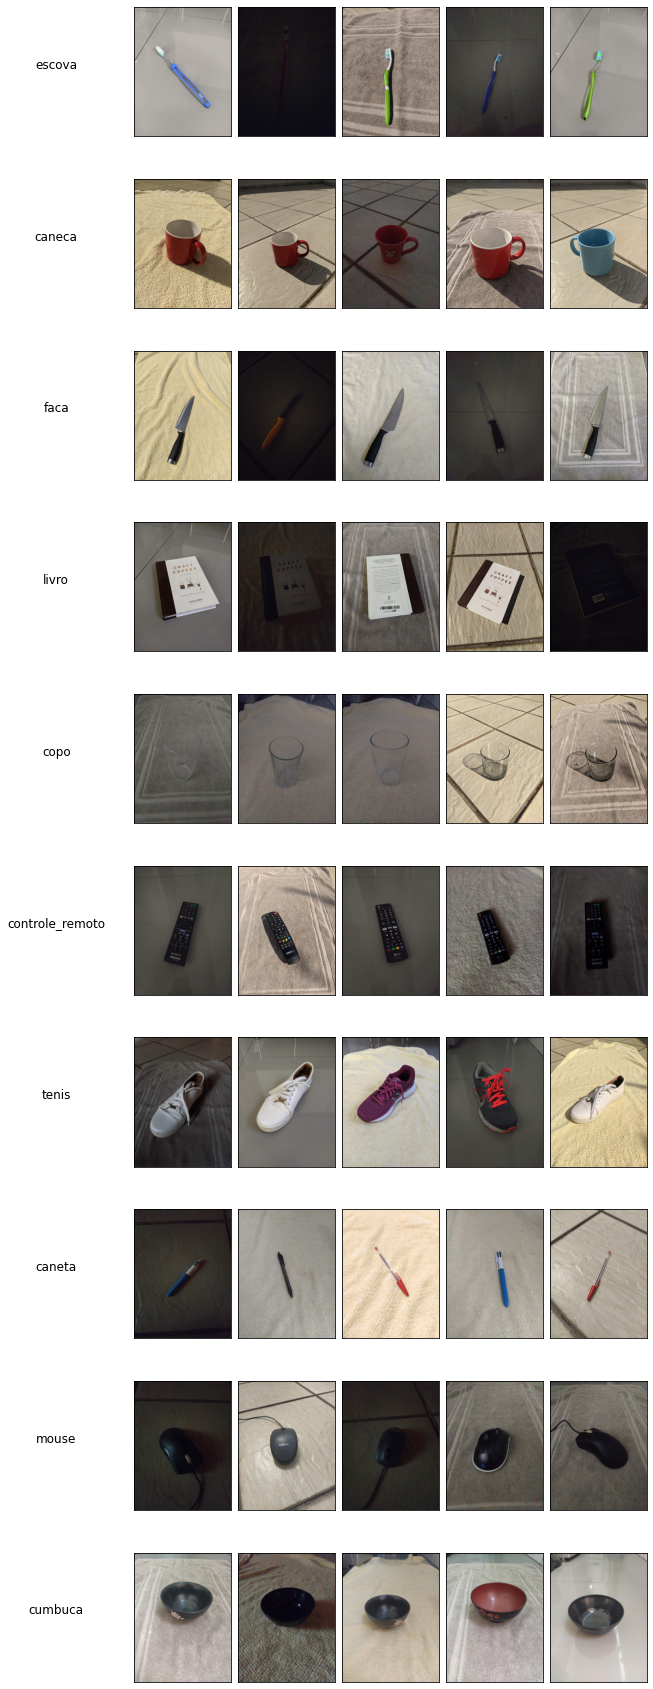

In [7]:
plt_samples()

## Data Augmentation (Parte 1) - RGB2Gray

O primeiro passo é converter cada imagem da base para _grayscale_. Para isso, utilizamos a função **rgb2gray** da biblioteca sklearn, aplicando a função a cada imagem da base e prefixando a string "gray" ao nome do arquivo, que é salvo localmente no disco.

In [8]:
def augment_rgb2gray(df, debug=False):
    db_path = "./ep_data/"
    for i in range(len(df.index)):
        filename = df.iloc[i].arquivo
        img = io.imread(db_path + filename)
        gray_img = (rgb2gray(img) * 256).astype("uint8")
        new_path = db_path + "gray_" + filename
        io.imsave(new_path, gray_img)
        if debug is True:
            print("augment_rgb2gray: " + new_path)
            clear_output(wait=True)

Como precisaremos dessas imagens em tons de cinza, criamos também um novo DataFrame a partir do DataFrame original, atualizando o nome dos arquivos para que correspondam às imagens em tons de cinza criadas.

In [ ]:
augment_rgb2gray(df, debug=True)

In [9]:
orig_gray_df = df.assign(arquivo=lambda x: "gray_" + x.arquivo)

## Data Augmentation (Parte 2) - Algoritmos

Feita a conversão das imagens da base para tons de cinza, podemos agora aplicar os algoritmos de _data augmentation_, gerando novamente novas imagens com nomes prefixados, que serão salvas em nossa base.

As funções recebem como argumento o DataFrame das imagens em tons de cinza e, se preciso, variáveis numéricas que alteram propriedades dos algoritmos.

In [10]:
def augment_shading(df, debug=False):
    db_path = "./ep_data/"
    sample_img = io.imread(db_path + df.iloc[0].arquivo)
    y, x = sample_img.shape
    X = np.linspace(255, 0, x).astype("uint8")
    G = np.tile(X, (y, 1))
    for filename in df.arquivo:
        img = io.imread(db_path + filename)
        proc_img = img.astype("float")
        proc_img += G
        proc_img[proc_img>255] = 255
        proc_img = proc_img.astype("uint8")
        new_path = db_path + "shade_" + filename
        io.imsave(new_path, proc_img)
        if debug is True:
            print("augment_shading: " + new_path)
            clear_output(wait=True)
            
def augment_log(df, c, debug=False):
    db_path = "./ep_data/"
    for filename in df.arquivo:
        img = io.imread(db_path + filename)
        proc_img = np.copy(img).astype("float") + 1
        proc_img = c * np.log(proc_img)
        proc_img[proc_img > 255] = 255
        proc_img = proc_img.astype("uint8")
        new_path = db_path + "log_" + filename
        io.imsave(new_path, proc_img)
        if debug is True:
            print("augment_log: " + new_path)
            clear_output(wait=True)
            
def augment_exp(df, c, gamma, debug=False):
    db_path = "./ep_data/"
    for filename in df.arquivo:
        img = io.imread(db_path + filename)
        proc_img = np.copy(img).astype("float")
        proc_img = c * np.power(proc_img, gamma)
        proc_img[proc_img>255] = 255
        proc_img = proc_img.astype("uint8")
        new_path = db_path + "exp_" + filename
        io.imsave(new_path, proc_img)
        if debug is True:
            print("augment_log: " + new_path)
            clear_output(wait=True)
                  
def augment_mean(df, kernel, debug=False):
    db_path = "./ep_data/"
    for filename in df.arquivo:
        img = io.imread(db_path + filename)
        proc_img = cv2.blur(img, kernel)
        new_path = db_path + "mean_" + filename
        io.imsave(new_path, proc_img)
        if debug is True:
            print("augment_mean: " + new_path)
            clear_output(wait=True)

Agora, basta executarmos cada uma das funções com os argumentos adequados. 

Ao final do processamento, o diretório _ep_data_, que contém todas as imagens do dataset, deverá ter cerca de 2.1GB.

In [ ]:
#augment_shading(orig_gray_df, debug=True)
#augment_log(orig_gray_df, 255/np.log(256), debug=True)
augment_exp(orig_gray_df, 1.05, 1.05, debug=True)
#augment_mean(orig_gray_df, (5,5), debug=True)

augment_log: ./ep_data/exp_gray_photo_0169.jpg


Criadas todas as imagens filtradas, agora atualizamos nosso dataframe com essas informações, anexando uma nova linha para cada imagem com o nome do arquivo atualizado, e contando cada imagem processada como uma nova repetição de determinada configuração de iluminação.

Em seguida, para verificarmos que tudo está em ordem, vemos as informações das tabelas sumárias.

In [22]:
aug_df = orig_gray_df.copy(deep=True)
shade_df = aug_df.assign(arquivo=lambda x: "shade_" + x.arquivo, numero=lambda x: x.numero + 3)
log_df = aug_df.assign(arquivo=lambda x: "log_" + x.arquivo, numero=lambda x: x.numero + 6)
exp_df = aug_df.assign(arquivo=lambda x: "exp_" + x.arquivo, numero=lambda x: x.numero + 9)
mean_df = aug_df.assign(arquivo=lambda x: "mean_" + x.arquivo, numero=lambda x: x.numero + 12)

aug_df = aug_df.append(shade_df, ignore_index=True)
aug_df = aug_df.append(log_df, ignore_index=True)
aug_df = aug_df.append(exp_df, ignore_index=True)
aug_df = aug_df.append(mean_df, ignore_index=True)

del(shade_df)
del(log_df)
del(exp_df)
del(mean_df)

In [23]:
show_summary_table(aug_df)

Tabela Global Sumária
Número de classes     | 10
Número de imagens     | 7740
Tamanho da base (MB)  | 2054.7223443984985
Resolução das imagens | (1440, 1920)

Tabela detalhada - Classe "escova"
Nome             | escova
Total de imagens | 900
Objetos          | 5
-----------------------------------------
Fundos           | piso_textura
                 | toalha_marrom
                 | toalha_amarela
                 | piso_liso
-----------------------------------------
Iluminação       | ['fora' 'dia']
                 | ['dentro' 'dia']
                 | ['fora' 'noite']
                 | ['dentro' 'noite']
-----------------------------------------
Repetições       | 15

Tabela detalhada - Classe "caneca"
Nome             | caneca
Total de imagens | 720
Objetos          | 4
-----------------------------------------
Fundos           | piso_textura
                 | toalha_amarela
                 | toalha_marrom
                 | piso_liso
----------------------------------------

## Extra: Normalização de Histograma

A seguir, aplicaremos a normalização de histograma em algumas imagens de nosso dataset. Tendo em mente que o que foi visto em aula se aplicava somente a imagens monocromáticas, devemos converter as imagens para tons de cinza.

A função abaixo faz a normalização do histograma "passo a passo":
1. Obtém o histograma da imagem
2. Aplica a transformação $s_k = T(r_k) = (L-1)\sum_{j=0}^{k}p_r(r_j) \quad k=0,1,2\dots,L-1$, obtendo o vetor $s$
3. Os valores de $s$ são divididos pelas dimensões da imagem $MN$ e arredondados para o inteiro mais próximo dentro do intervalo $[0, L-1]$
4. Cada pixel com valor $i$ é substituído pelo valor dado por $s_i$ (ex: para $L=4$ e vetor $s = [3,1,2,0]$, pixels com valor 0 possuirão valor 3, com valor 1 continuarão 1, com valor 2 continuarão 2, e com valor 3 possuirão valor 0)

In [28]:
def normalize_histogram(img, bits=2**16):
    hist = np.zeros(bits)
    for pix in img.ravel():
        hist[pix] += 1
    
    s = np.zeros(bits)
    summation = 0
    for i in range(bits):
        summation += hist[i]
        s[i] = bits * summation
    s = s/bits
    s = np.rint(s).astype(int)
    
    norm_img = s[img]
            
    return norm_img

Vejamos o resultado para uma imagem qualquer, com iluminação de noite:

In [1]:
from skimage.exposure import equalize_hist

def plt_img_and_hist(img, axes):
    ax_img, ax_hist = axes
    
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_hist.hist(img.ravel(), bins=2**16, histtype='step', color='black')

    return ax_img, ax_hist

sample = df[(df['iluminacao'] == 'noite') & (df['classe'] == 'livro')].sample(n=1)
sample_path = "./ep_data/" + sample.arquivo
sample_img = io.imread(sample_path, as_gray=True)
sample_img = img_as_uint(sample_img)
norm_img = normalize_histogram(sample_img)
sample_img = equalize_hist(sample_img)
print(type(sample_img))
print(type(sample_img[0][0]))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
ax_img, ax_hist = plt_img_and_hist(sample_img, axes[:, 0])
ax_img, ax_hist = plt_img_and_hist(norm_img, axes[:, 1])
fig.tight_layout()
plt.show()

NameError: name 'df' is not defined

In [32]:
sample_img

array([[0.61333514, 0.55324291, 0.55324291, ..., 0.81694191, 0.78206995,
        0.78206995],
       [0.49323785, 0.49323785, 0.43398293, ..., 0.81694191, 0.78206995,
        0.73896159],
       [0.43398293, 0.43398293, 0.37384512, ..., 0.81694191, 0.78206995,
        0.73896159],
       ...,
       [0.21882921, 0.21882921, 0.13997613, ..., 0.01211516, 0.01211516,
        0.00430592],
       [0.21882921, 0.21882921, 0.13997613, ..., 0.00430592, 0.00430592,
        0.01211516],
       [0.21882921, 0.21882921, 0.13997613, ..., 0.00430592, 0.00430592,
        0.01211516]])

In [33]:
norm_img

array([[1695749, 1529606, 1529606, ..., 2258681, 2162267, 2162267],
       [1363704, 1363704, 1199876, ..., 2258681, 2162267, 2043081],
       [1199876, 1199876, 1033607, ..., 2258681, 2162267, 2043081],
       ...,
       [ 605019,  605019,  387006, ...,   33496,   33496,   11905],
       [ 605019,  605019,  387006, ...,   11905,   11905,   33496],
       [ 605019,  605019,  387006, ...,   11905,   11905,   33496]])